In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skewnorm, skew, norm, shapiro

In [2]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

In [3]:
def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [4]:
X = gen_skewnormal(5, 2, 4, 100000, 42)
X.var()

2.004927890730308

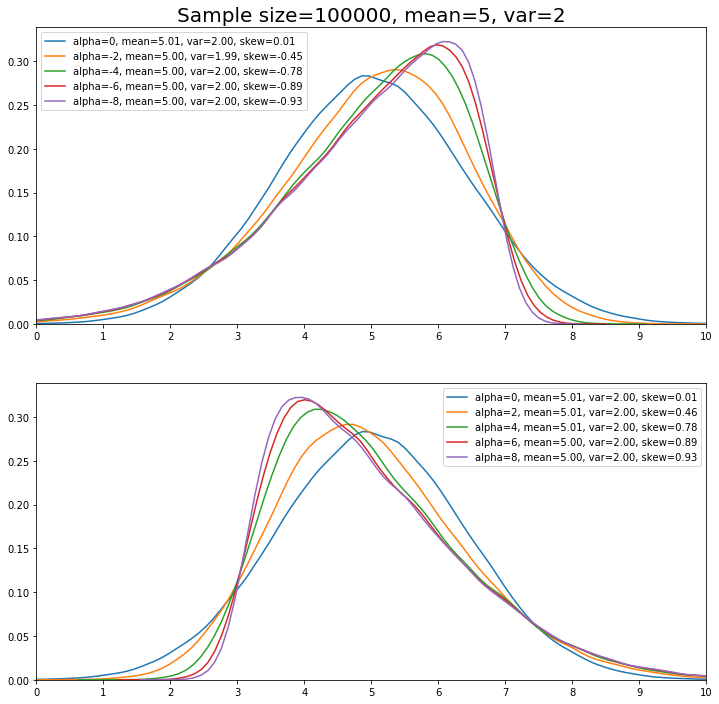

In [5]:
size = 100000
mean = 5
var = 2

fig, axs = plt.subplots(figsize=(12, 12), nrows=2)
for alpha in np.arange(0, 10, 2):
    alpha *= -1
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[0])

for alpha in np.arange(0, 10, 2):
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[1])
    
title = f'Sample size={size}, mean={mean}, var={var}'
axs[0].set_title(title, fontsize=20)
axs[0].set_xlim([mean-5, mean+5])
axs[0].set_xticks([i for i in range(0, 11)])
axs[1].set_xlim([mean-5, mean+5])
axs[1].set_xticks([i for i in range(0, 11)]);

### Find the experiment alpha values

In [6]:
### find a random seed that the skewness of generated X is close to theory value

alphas = np.arange(0.15, 1.65, 0.3)

size = 4500
for alpha in alphas:
    for _ in range(100):
        rseed = np.random.randint(0, 200)
        X = gen_skewnormal(0, 2, alpha, size, rseed)
        if alpha == 0:
            if np.abs(skew(X)) <= 0.01:
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
        else:
            if np.abs(skew(X) - tskew(alpha)) <= 0.1 * tskew(alpha):
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
    else:
        print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}'
              + '  FAIL to find the best rseed.')

alpha = 0.15, rseed =  43, tskew = 0.001, skew =  0.026  FAIL to find the best rseed.
alpha = 0.45, rseed =  31, tskew = 0.018, skew =  0.018
alpha = 0.75, rseed =  87, tskew = 0.070, skew =  0.070
alpha = 1.05, rseed = 191, tskew = 0.152, skew =  0.152
alpha = 1.35, rseed =  14, tskew = 0.250, skew =  0.251


,mean,var,tskew,skew,W,p-value
0.15,0.000881,1.934791,0.001,0.033,1.000,0.66832
0.45,-0.007957,1.930086,0.018,0.018,1.000,0.73021
0.75,-0.028184,1.961639,0.070,0.075,0.999,0.05804
1.05,0.013837,1.931826,0.152,0.161,0.998,0.00006
1.35,-0.004664,1.996977,0.250,0.226,0.997,0.00000


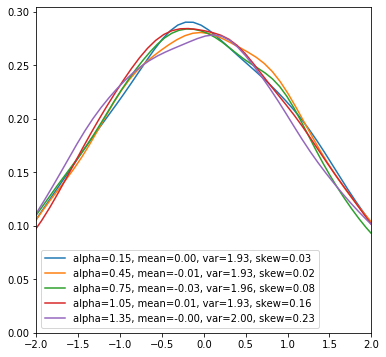

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

result = {}
rseeds = [58, 97, 0, 124, 132]
for rseed, alpha in zip(rseeds, alphas):
    X = gen_skewnormal(0, 2, alpha, size, rseed)
    W, p = shapiro(X)
    result[alpha] = [X.mean(), X.var(), tskew(alpha), skew(X), W, p]
    label = f'alpha={alpha:.2f}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}'
    sns.kdeplot(X, label=label, ax=ax)
    
ax.set_xlim([-2, 2])

df = pd.DataFrame(result, index=['mean', 'var', 'tskew', 'skew', 'W', 'p-value']).T
df.index.name = 'alpha'

df_s = df.copy()
df_s.index = [f'{idx:.2f}' for idx in df_s.index]
df_s['tskew'] = df_s['tskew'].map(lambda y: f'{y:.3f}')
df_s['skew'] = df_s['skew'].map(lambda y: f'{y:.3f}')
df_s['W'] = df_s['W'].map(lambda y: f'{y:.3f}')
df_s['p-value'] = df_s['p-value'].map(lambda y: f'{y:.5f}')
df_s

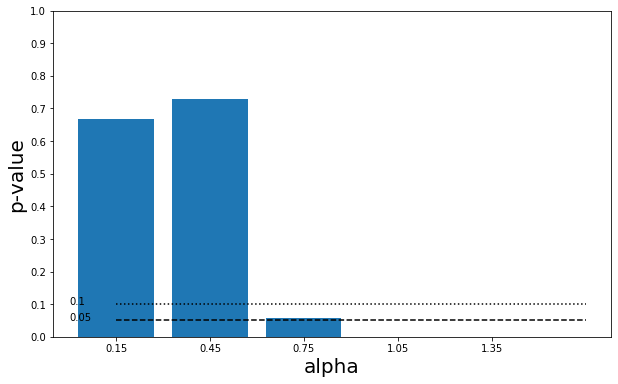

In [8]:
plt.figure(figsize=(10, 6))
x = df_s.index.values
p = df['p-value'].values
plt.bar(x, p)

plt.hlines(0.1, 0, len(alphas), ls='dotted')
plt.hlines(0.05, 0, len(alphas), ls='dashed')
plt.text(-0.5, 0.1, '0.1')
plt.text(-0.5, 0.05, '0.05')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('alpha', fontsize=20)
plt.ylabel('p-value', fontsize=20);

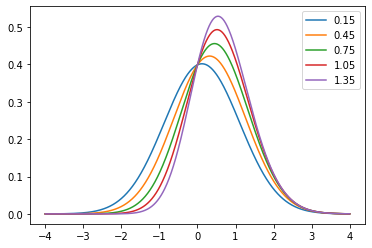

In [12]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, skewnorm.pdf(x, 0.15), label='0.15')
plt.plot(x, skewnorm.pdf(x, 0.45), label='0.45')
plt.plot(x, skewnorm.pdf(x, 0.75), label='0.75')
plt.plot(x, skewnorm.pdf(x, 1.05), label='1.05')
plt.plot(x, skewnorm.pdf(x, 1.35), label='1.35')
plt.legend()

### 測試 skewnorm 的 sampling error。看樣本數要多少，用正負alpha各自計算出來的偏度才會同值異號

In [13]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

size = 50
alpha = 0.4:   skew=0.45832470051416213
alpha = -0.4:  skew=-0.016565702271752174
size = 100
alpha = 0.4:   skew=-0.07805419245782044
alpha = -0.4:  skew=-0.1496611857354845
size = 1000
alpha = 0.4:   skew=0.02190844102157276
alpha = -0.4:  skew=0.04920773332541458
size = 10000
alpha = 0.4:   skew=0.022830276152580226
alpha = -0.4:  skew=-0.05719003834555021
size = 100000
alpha = 0.4:   skew=0.005149639322133145
alpha = -0.4:  skew=-0.012780302873465548
size = 1000000
alpha = 0.4:   skew=0.01104694349867342
alpha = -0.4:  skew=-0.01258824496414467
size = 2000000
alpha = 0.4:   skew=0.012540590848888733
alpha = -0.4:  skew=-0.01245645065565107
size = 5000000
alpha = 0.4:   skew=0.013176557559988646
alpha = -0.4:  skew=-0.014124224306124214


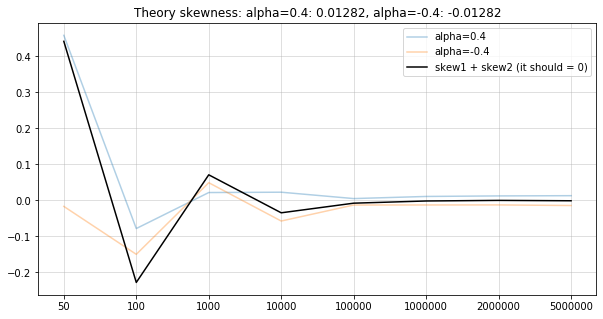

In [14]:
### alpha = 0.4 or -0.4

alpha = 0.4
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度，似乎要到萬等級的樣本數，偏度值才會比較穩定
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

size = 50
alpha = 2.5:   skew=0.7823186511792708
alpha = -2.5:  skew=-0.46829316711485947
size = 100
alpha = 2.5:   skew=0.38541260214994005
alpha = -2.5:  skew=-0.2773178393543375
size = 1000
alpha = 2.5:   skew=0.657084161397756
alpha = -2.5:  skew=-0.5248741555034038
size = 10000
alpha = 2.5:   skew=0.5661096965510987
alpha = -2.5:  skew=-0.5638216507492888
size = 100000
alpha = 2.5:   skew=0.5724326776381582
alpha = -2.5:  skew=-0.5857921894877215
size = 1000000
alpha = 2.5:   skew=0.5748143219647873
alpha = -2.5:  skew=-0.577078849107644
size = 2000000
alpha = 2.5:   skew=0.576236733485582
alpha = -2.5:  skew=-0.5768747492741795
size = 5000000
alpha = 2.5:   skew=0.5773564632050936
alpha = -2.5:  skew=-0.5772484500173382


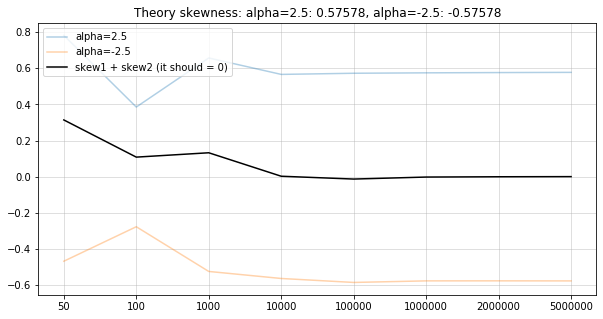

In [15]:
### alpha = 2.5 or -2.5

alpha = 2.5
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

# 似乎alpha大時，算出來的樣本偏度比alpha小時還要更快收斂

### kurtosis

In [16]:
def sinh_arcsinh_transform(x, epsilon, delta):
    return np.sinh(delta*np.arcsinh(x)-epsilon) * delta * np.cosh(delta*np.arcsinh(x)-epsilon) / np.sqrt(1+x**2)

(array([ 6., 11., 10., 10., 19., 15., 12.,  8.,  5.,  4.]),
 array([-2.22602746, -1.766147  , -1.30626654, -0.84638608, -0.38650562,
         0.07337484,  0.5332553 ,  0.99313576,  1.45301622,  1.91289668,
         2.37277714]),
 <a list of 10 Patch objects>)

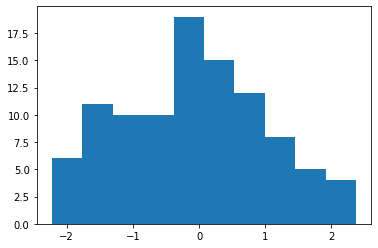

In [17]:
x = np.random.normal(loc=0, scale=1, size=100)
plt.hist(x)

(array([ 5.,  7., 14.,  8., 25., 21.,  8.,  5.,  3.,  4.]),
 array([-4.95396119, -3.91815667, -2.88235215, -1.84654763, -0.81074311,
         0.22506141,  1.26086593,  2.29667045,  3.33247497,  4.36827949,
         5.40408401]),
 <a list of 10 Patch objects>)

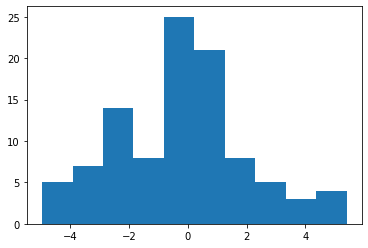

In [18]:
plt.hist(sinh_arcsinh_transform(x, 0, 1.2))

In [19]:
from scipy.special import kv

def P(q):
    return np.exp(1)**0.25 * (kv(q/2+0.5, 0.25) + kv(q/2-0.5, 0.25)) / np.sqrt(8*np.pi)

def moments(epsilon, delta):
    m1 = np.sinh(epsilon/delta) * P(1/delta)
    m2 = 0.5 * np.cosh(2*epsilon/delta) * P(2/delta) - 0.5
    m3 = 0.25 * (np.sinh(3*epsilon/delta) * P(3/delta) - 3 * np.sinh(epsilon/delta) * P(1/delta))
    m4 = 0.125 * (np.cosh(4*epsilon/delta) * P(4/delta) - 4 * np.cosh(2*epsilon/delta) * P(2/delta) + 3)
    return (m1, m2, m3, m4)

In [23]:
from scipy.stats import kurtosis, skew

m1, m2, m3, m4 = moments(0, 1.2)
v = m2 - m1**2
print(m4/v**2-3)

ss = []
for i in range(1000):
    x = np.random.normal(loc=0, scale=1, size=200)
    s = sinh_arcsinh_transform(x, 0, 1.2)
    ss.append(kurtosis(s))
print(np.mean(ss))

-0.3082349001449778
1.4655335533261808


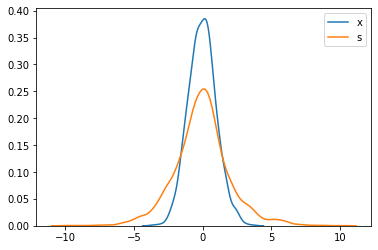

In [24]:
x = np.random.normal(loc=0, scale=1, size=2000)
s = sinh_arcsinh_transform(x, 0, 1.2)

fig, ax = plt.subplots()
sns.kdeplot(x, label='x', ax=ax)
sns.kdeplot(s, label='s', ax=ax)

In [25]:
from scipy.stats import kurtosis, skew

def simu_mvsk(loc, scale, epsilon, delta):
    hmean = []
    hvar = []
    hskew = []
    hkurt = []
    for i in range(1000):
        x = np.random.normal(loc=loc, scale=scale, size=2000)
        s = sinh_arcsinh_transform(x, epsilon, delta)
        hmean.append(s.mean())
        hvar.append(s.var())
        hskew.append(skew(s))
        hkurt.append(kurtosis(s))

    return np.mean(hmean), np.mean(hvar), np.mean(hskew), np.mean(hkurt) 
    
simu_mvsk(0, 1, 0, 1.2)

(-0.0005098722446287838,
 3.957435554948953,
 -0.0032650355051575355,
 1.6226087959579074)

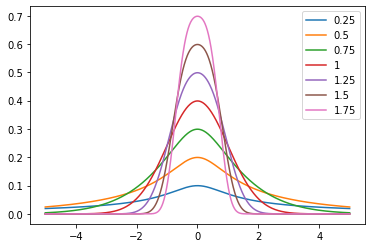

In [26]:
from scipy.stats import rv_continuous

class sinh_arcsinh(rv_continuous):
    epsilon = 0
    delta = 1
    
    def _pdf(self, x):
        epsilon = self.epsilon
        delta = self.delta
        
        p1 = 1/np.sqrt(2*np.pi) * np.exp(np.sinh(delta*np.arcsinh(x)-epsilon)**2 / -2) 
        p2 = np.cosh(delta * np.arcsinh(x) - epsilon) * delta / np.sqrt(1+x**2)
        return p1 * p2


my_cv = sinh_arcsinh()
my_cv.epsilon

x = np.linspace(-5, 5, 1000)
for e in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]:
    my_cv.delta = e
    plt.plot(x, my_cv.pdf(x), label=str(e))
plt.legend(loc='upper right')

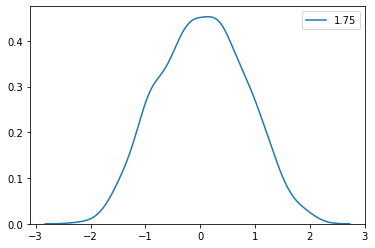

In [27]:
fig, ax = plt.subplots()

my_cv.delta = 1.2
samples = my_cv.rvs(size=1000)
sns.kdeplot(samples, label=str(e), ax=ax)

In [28]:
shapiro(samples)

(0.9948376417160034, 0.001731709111481905)

In [29]:
my_cv.epsilon = 0
my_cv.delta = 1
my_cv.var(scale=np.sqrt(2))

1.9999999986137917

### Test bias normal

In [88]:
from scipy.stats import ttest_1samp

ss = np.random.normal(0.2, np.sqrt(2), size=200)
ttest_1samp(ss, 0)[1]

0.07597024306155457

In [114]:
p_dict = {}
for m in np.arange(0, 0.55, 0.05):
    p = []
    for i in range(100):
        ss = np.random.normal(m, np.sqrt(2), size=200)
        pvalue = ttest_1samp(ss, 0)[1]
        p.append(pvalue)
    print(f'm: {m:3.2f}, pvalue: {np.mean(p)}')
    p_dict[f'{m:3.2f}'] = np.mean(p)

m: 0.00, pvalue: 0.48625039820402643
m: 0.05, pvalue: 0.4709060083067789
m: 0.10, pvalue: 0.3582297928897117
m: 0.15, pvalue: 0.24942606387403546
m: 0.20, pvalue: 0.15393901320369047
m: 0.25, pvalue: 0.06951577940480416
m: 0.30, pvalue: 0.03609094573248423
m: 0.35, pvalue: 0.0069141678344126125
m: 0.40, pvalue: 0.00762664988817082
m: 0.45, pvalue: 0.0006020966119367783
m: 0.50, pvalue: 0.0003222585883422607


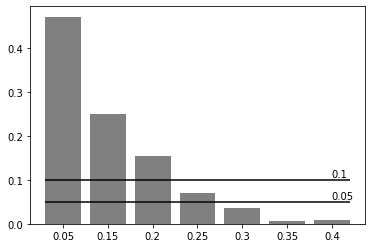

In [135]:
p = [0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for i in range(len(p)):
    plt.bar(i, p_dict[f'{p[i]:3.2f}'], color='grey')
plt.xticks(list(range(len(p))), p)
plt.hlines([0.05, 0.1], -0.4, 6.4)
plt.text(6, 0.055, '0.05')
plt.text(6, 0.105, '0.1');